In [ ]:
import numpy as np
import pandas as pd

from datetime import datetime
from matplotlib import pyplot as plt
import os
from tqdm.notebook import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Poisson

class WordFish():
    """
    WordFish is a scaling model for estimating latent traits from word frequencies.
    It's commonly used in political science for analyzing political positions in text.
    """

    def __init__(self, dw_matrix):
        """
        Initialize the WordFish model.

        Input:
        - dw_matrix: Document-word matrix (numpy array or torch tensor)

        Output:
        - None (initializes model parameters)
        """
        self.dw_matrix = torch.tensor(dw_matrix)
        self.N = self.dw_matrix.shape[0]  # Number of documents
        self.V = self.dw_matrix.shape[1]  # Vocabulary size
        self.Freq = dw_matrix.sum(axis=0)  # Word frequencies across all documents

        # Initialize model parameters
        colMean = np.log1p(dw_matrix.mean(axis=0).reshape((1,-1)))
        rowMean = np.log1p(dw_matrix.mean(axis=1).reshape((-1,1)))

        self.alpha = nn.Parameter(torch.tensor(rowMean))  # Document fixed effects
        self.psi = nn.Parameter(torch.tensor(colMean))    # Word fixed effects
        self.beta = nn.Parameter(torch.rand(1, self.V))   # Word weights
        self.theta = nn.Parameter(torch.rand(self.N, 1))  # Document positions

        # Initialize optimizer
        self.optimizer = optim.Adam([self.alpha, self.psi, self.beta, self.theta], lr=0.05)

    def compute_lambda(self, alpha, psi, beta, theta):
        """
        Compute the expected word frequencies (lambda) for each document-word pair.

        Input:
        - alpha, psi, beta, theta: Model parameters

        Output:
        - lambda_ij: Expected word frequencies
        """
        eta = alpha + psi + torch.matmul(theta, beta)
        lambda_ij = torch.exp(eta)
        return lambda_ij

    def poisson_nll_loss(self, y_true, y_pred):
        """
        Compute the Poisson negative log-likelihood loss.

        Input:
        - y_true: Observed word frequencies
        - y_pred: Predicted word frequencies (lambda)

        Output:
        - loss: Negative log-likelihood loss
        """
        epsilon = 1e-8
        loss = -Poisson(y_pred).log_prob(y_true)
        return loss.sum()

    def train(self, num_epochs=500):
        """
        Train the WordFish model.

        Input:
        - num_epochs: Number of training epochs

        Output:
        - loss_record: List of loss values for each epoch
        """
        loss_record = []
        pb = tqdm(total=num_epochs)
        for epoch in range(num_epochs):
            self.optimizer.zero_grad()

            lambda_ij = self.compute_lambda(self.alpha, self.psi, self.beta, self.theta)

            loss = self.poisson_nll_loss(self.dw_matrix, lambda_ij)
            loss.backward()

            self.optimizer.step()

            pb.update(1)
            pb.set_description(f"loss: {loss.item():.2f}")
            loss_record.append(loss.item())

        # Store final parameter estimates
        self.beta_hat = self.beta.detach().numpy().squeeze()
        self.psi_hat = self.psi.detach().numpy().squeeze()
        self.alpha_hat = self.alpha.detach().numpy().squeeze()
        self.theta_hat = self.theta.detach().numpy().squeeze()
        return loss_record

    def get_top_n_arg(self, arr, n):
        """
        Get indices of top n values in an array.

        Input:
        - arr: Input array
        - n: Number of top values to retrieve

        Output:
        - Indices of top n values
        """
        return np.argpartition(arr, -n)[-n:]

    def stdz(self, x):
        """
        Standardize an array (zero mean, unit variance).

        Input:
        - x: Input array

        Output:
        - Standardized array
        """
        return (x - x.mean()) / x.std()

    def wordplot(self, beta=None, psi=None, corpus=None, standarized=True, highlighted=10, alpha=0.05):
        """
        Generate plots to visualize word importances and frequencies.

        Input:
        - beta, psi: Model parameters (use estimated if None)
        - corpus: List of words (use indices if None)
        - standarized: Whether to standardize beta and psi
        - highlighted: Number of words to highlight or list of specific words
        - alpha: Transparency of scatter points

        Output:
        - DataFrame of highlighted words and their beta values
        """
        if beta is None:
            beta = self.beta_hat
        if psi is None:
            psi = self.psi_hat

        if corpus is None:
            corpus = np.arange(self.V)

        if isinstance(highlighted, int):
            top_word_id = self.get_top_n_arg(beta, highlighted)
            bottom_word_id = self.get_top_n_arg(-beta, highlighted)
            top_word = [corpus[id] for id in top_word_id]
            bottom_word = [corpus[id] for id in bottom_word_id]

        if isinstance(highlighted, list):
            top_word_id = [corpus.index(w) for w in highlighted]
            top_word = highlighted
            bottom_word_id = []
            bottom_word = []

        if standarized:
            beta = self.stdz(beta)
            psi = self.stdz(psi)

        plt.figure(figsize= (10, 5))
        plt.subplot(1,2,1)
        plt.scatter(beta, np.log1p(self.Freq), marker = "+", color="brown",alpha = alpha)
        plt.xlabel('Estimated $\\beta$')
        plt.ylabel("Word Frequency in logarithm scale")
        for i in range(len(top_word)):
          plt.annotate(top_word[i], (beta[top_word_id[i]], np.log1p(self.Freq[top_word_id[i]])))
        for i in range(len(bottom_word)):
          plt.annotate(bottom_word[i], (beta[bottom_word_id[i]], np.log1p(self.Freq[bottom_word_id[i]])))

        plt.subplot(1,2,2)
        plt.scatter(beta, psi, marker = "+", color="royalblue",alpha = alpha)
        plt.xlabel('Estimated $\\beta$')
        plt.ylabel('Estimated $\\psi$')
        for i in range(len(top_word)):
          plt.annotate(top_word[i], (beta[top_word_id[i]], psi[top_word_id[i]]))
        for i in range(len(bottom_word)):
          plt.annotate(bottom_word[i], (beta[bottom_word_id[i]], psi[bottom_word_id[i]]))
        plt.show()
        plt.close()

        highligthed_word = [[top_word[i] for i in range(len(top_word))] + [bottom_word[i] for i in range(len(bottom_word))],
                            [beta[top_word_id[i]] for i in range(len(top_word))] + [beta[bottom_word_id[i]] for i in range(len(bottom_word))]]
        highligthed_word = pd.DataFrame(highligthed_word).T
        highligthed_word.columns = ["word", "beta_hat"]
        highligthed_word.sort_values(by="beta_hat", ascending=False, inplace=True)

        return highligthed_word

Wordfish Implementation using Pytorch
The orignal model design can be found in the [manual](http://www.wordfish.org/uploads/1/2/9/8/12985397/wordfish_manual.pdf)

The same example in https://tutorials.quanteda.io/machine-learning/wordfish/


In [ ]:
dw_matrix = pd.read_excel("demo/dfmat_irish.xlsx")
dw_matrix = dw_matrix.astype(int)
corpus = dw_matrix.columns.to_list()

  0%|          | 0/500 [00:00<?, ?it/s]

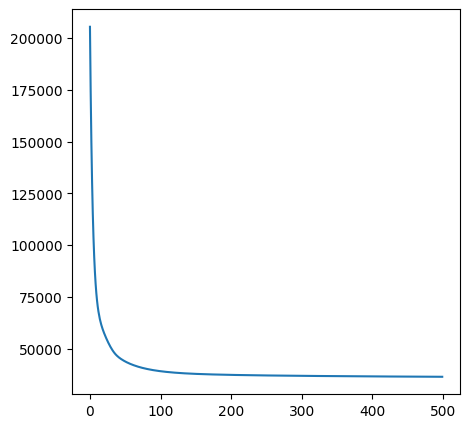

In [ ]:
wordfish = WordFish(dw_matrix.values)
loss_record = wordfish.train(num_epochs=500)
plt.figure(figsize=(5,5))
plt.plot(loss_record)
plt.show()
plt.close()

Here I implemented a function to visualize the word distribution and

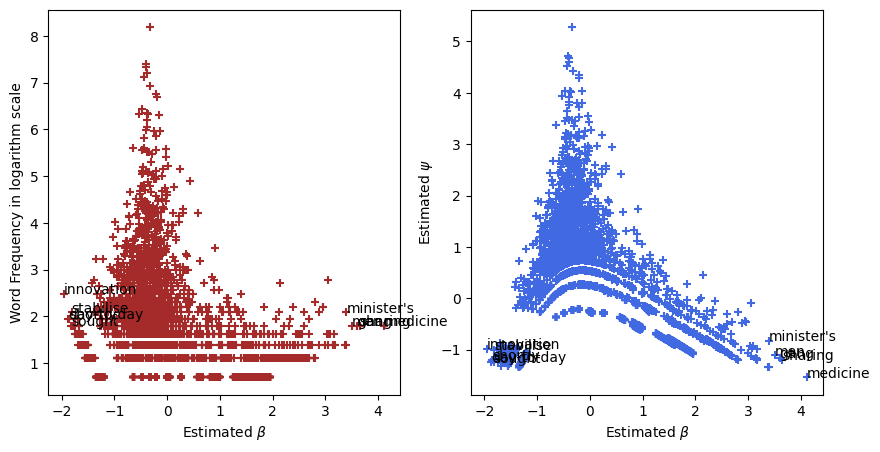

,word,beta_hat
0,minister's,3.40054
1,men,3.503838
2,gang,3.596227
3,sharing,3.651785
4,medicine,4.120302
5,stabilise,-1.812516
6,sought,-1.825009
7,shortly,-1.859818
8,day-to-day,-1.879751
9,innovation,-1.953522


In [ ]:
highlighted_word = wordfish.wordplot(corpus = corpus, highlighted = 5)
highlighted_word

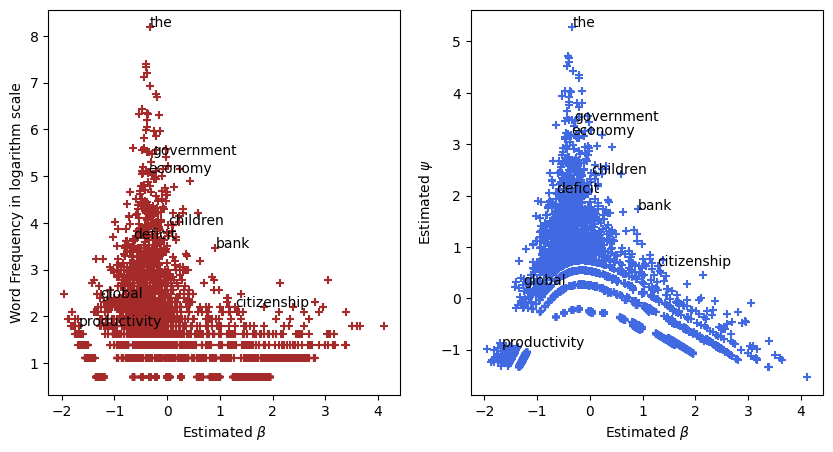

,word,beta_hat
0,government,-0.291155
1,global,-1.269551
2,children,0.02277
3,bank,0.91583
4,economy,-0.354243
5,the,-0.331887
6,citizenship,1.284637
7,productivity,-1.673421
8,deficit,-0.641069


In [ ]:
highlighted_word = wordfish.wordplot(corpus = corpus, highlighted = ["government", "global", "children",
                                 "bank", "economy", "the", "citizenship",
                                 "productivity", "deficit"])
highlighted_word